# Investigate the ethnobotanical patterns of medicinal plants containing atropine

### Import modules

In [1]:
import logging
from collections import defaultdict
from typing import List

import pandas as pd
from tqdm import tqdm
import obonet
import networkx as nx

# Phylogenetics
from ete3 import NCBITaxa

# Viz
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 360

In [4]:
logging.disable()
pd.options.mode.chained_assignment = None

In [5]:
DATA_DIR = '../data/processed'
MAPPING_DIR = '../data/mapping'

### Load plant-disease evidences

In [6]:
plant_disease_df = pd.read_csv(
    f'{DATA_DIR}/plant_disease_collapsed.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'disease_curie',
        'database'
    ],
    low_memory=False
)
plant_disease_df.head(1)

,plant_curie,disease_curie,database
0,ncbitaxon:3369,mondo:0024623,bern2


In [7]:
medicinal_plants = plant_disease_df['plant_curie'].unique().tolist()

len(medicinal_plants)

5636

In [8]:
plant_chemical_df = pd.read_csv(
    f'{DATA_DIR}/plant_chemical_associations.tsv.zip',
    compression='zip',
    sep='\t',
    usecols=[
        'plant_curie',
        'plant name',
        'chemical_curie',
        'evidence'
    ],
    low_memory=False
)

plant_chemical_df.rename(columns={'plant name': 'plant_name'}, inplace=True)

plant_chemical_df.head(1)

,plant_curie,plant_name,chemical_curie,evidence
0,ncbitaxon:1000425,Pimpinella major,pubchem.compound:3527,Relation from COCONUT


### Map disease curies to disease names

In [9]:
url = 'http://purl.obolibrary.org/obo/mondo.obo'
mondo_graph = obonet.read_obo(url)

In [10]:
disease_mapper = {
    id_.lower(): data.get('name')
    for id_, data in mondo_graph.nodes(data=True)
}

In [11]:
plant_disease_df['disease_name'] = plant_disease_df['disease_curie'].map(disease_mapper)

This might take a bit...

In [12]:
graph = obonet.read_obo('http://purl.obolibrary.org/obo/ncbitaxon.obo')

# Get the childs of Viridiplantae (all plants)
plant_childs = nx.ancestors(graph, 'NCBITaxon:33090')
# Subset the graph to make it faster to the relevant part (plants only)
graph = graph.subgraph(plant_childs)

In [13]:
plant_mapper = {
    id_.lower(): data.get('name')
    for id_, data in graph.nodes(data=True)
}

### Add genus information for plants

In [14]:
ncbi = NCBITaxa()

In [15]:
lineage_dict = defaultdict(list)
p_names = defaultdict(str)

for plant in tqdm(medicinal_plants):
    tree = ncbi.get_lineage(plant.split(':')[1])
    plant_name = ncbi.get_taxid_translator([plant.split(':')[1]])
    plant_name = {
        f'ncbitaxon:{i}': j
        for i, j in plant_name.items()
    }
    
    p_names.update(plant_name)
    
    tree = [
        f'ncbitaxon:{i}'
        for i in tree
    ]
    
    lineage_dict[plant] = tree

  2%|█▌                                                                                    | 99/5636 [00:00<00:05, 983.79it/s]/Users/danieldomingo/Downloads/ethnobotany/analysis/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 32224 was translated into 2843217
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
  4%|███▍                                                                                | 227/5636 [00:00<00:04, 1153.28it/s]/Users/danieldomingo/Downloads/ethnobotany/analysis/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 48038 was translated into 2849586
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
 10%|████████                                                                            | 539/5636 [00:00<00:03, 1435.52it/s]/Users/danieldomingo/Downloads/ethnobotany/analysis/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.p

In [16]:
plant_disease_df['parent'] = plant_disease_df['plant_curie'].map(lineage_dict)
plant_disease_df['plant_name'] = plant_disease_df['plant_curie'].map(plant_mapper)
# remove plant in genera which is the only poisoneous
plant_disease_df =  plant_disease_df[plant_disease_df['plant_curie'] != 'ncbitaxon:195737']

In [17]:
plant_disease_df.head(1)

,plant_curie,disease_curie,database,disease_name,parent,plant_name
0,ncbitaxon:3369,mondo:0024623,bern2,otorhinolaryngologic disease,"[ncbitaxon:1, ncbitaxon:131567, ncbitaxon:2759...",Cryptomeria japonica


Split the dataframe such that there is one plant-parent pair each row

In [18]:
plant_disease_df = plant_disease_df.explode(['parent'])

In [19]:
plant_disease_df.head(1)

,plant_curie,disease_curie,database,disease_name,parent,plant_name
0,ncbitaxon:3369,mondo:0024623,bern2,otorhinolaryngologic disease,ncbitaxon:1,Cryptomeria japonica


In [20]:
plant_chemical_df['parent'] = plant_chemical_df['plant_curie'].map(lineage_dict)

In [21]:
plant_chemical_df = plant_chemical_df.explode(['parent'])

### Usecase functions

In [22]:
def get_subset(parent_curies: str):
    """Get genus specific subset from the plant-disease data."""
    df = plant_disease_df[plant_disease_df['parent'].isin(parent_curies)]
    chem_df = plant_chemical_df[plant_chemical_df['parent'].isin(parent_curies)]
    
    print(f'No.of plants in the genus - {len(df.plant_curie.unique())}')
    print(f'No.of disease the genus treats - {len(df.disease_curie.unique())}')
    print(f'No.of chemicals the genus contains - {len(chem_df.chemical_curie.unique())}')
    
    return df , chem_df

In [23]:
def create_disease_matrix(df: pd.DataFrame):
    """Create a plant vs disease binary vector matrix"""
        
    dist_matrix = pd.DataFrame(
        columns=sorted([
            disease.capitalize()
            for disease in df['disease_name'].unique()
        ]),
        index=list(df['plant_name'].unique()),
    )
    dist_matrix.fillna(0, inplace=True)
    
    for row in tqdm(df.values):
        (
            plant_curie,
            disease_curie,
            source,
            disease_name,
            plant_family,
            plant_name
        ) = row

        dist_matrix.loc[plant_name, disease_name.capitalize()] = 1
    
    return dist_matrix

### Genera containing atropine

In [24]:
atropine_dis_df, atropine_chem_df = get_subset([
    'ncbitaxon:24609',
    'ncbitaxon:301914',
    'ncbitaxon:4281',
    'ncbitaxon:4074',
    'ncbitaxon:195735',
    'ncbitaxon:4078',
])

No.of plants in the genus - 21
No.of disease the genus treats - 23
No.of chemicals the genus contains - 547


Creating distance matrix for the subset

In [25]:
atropine_dis_distance_matrix = create_disease_matrix(atropine_dis_df)

100%|█████████████████████████████████████████████████████████████████████████████████████| 680/680 [00:00<00:00, 9060.15it/s]


In [26]:
# Plants having the chemical atropine
plants_of_interest = atropine_chem_df[
    atropine_chem_df.chemical_curie == 'pubchem.compound:174174'
].plant_name.unique()

In [27]:
def create_cluster(dist_df: pd.DataFrame, plants_of_interest: List):
    """Generating a clustermap for the data."""
    
    cmap = ListedColormap(['#cedeec', '#084c96'])
        
    g = sns.clustermap(
        dist_df, 
        cmap=cmap,
        fmt='g', 
        vmin=0,
        vmax=1, 
        yticklabels=dist_df.index, 
        xticklabels=True, 
        linecolor='white', 
        col_cluster=False,
        linewidths=.75,
        cbar_pos=None,
        metric="cosine",
        method="complete",
    )
        
    for tick_label in g.ax_heatmap.yaxis.get_majorticklabels():
        name = tick_label.get_text()
        if name in plants_of_interest:
            tick_label.set_weight('bold')
        else:
            tick_label.set_weight('normal')
            
    g.ax_heatmap.set_title(
        'Clustering medicinal plants in genera known to contain atropine',
        fontsize=18,
        y=1.05,
    )
    
    plt.tight_layout()
    plt.savefig(
        f'../data/figures/figure_6_clustering.png',
        dpi=400,
        bbox_inches='tight', 
    )
    
    plt.show()


Get clustermap for usecase

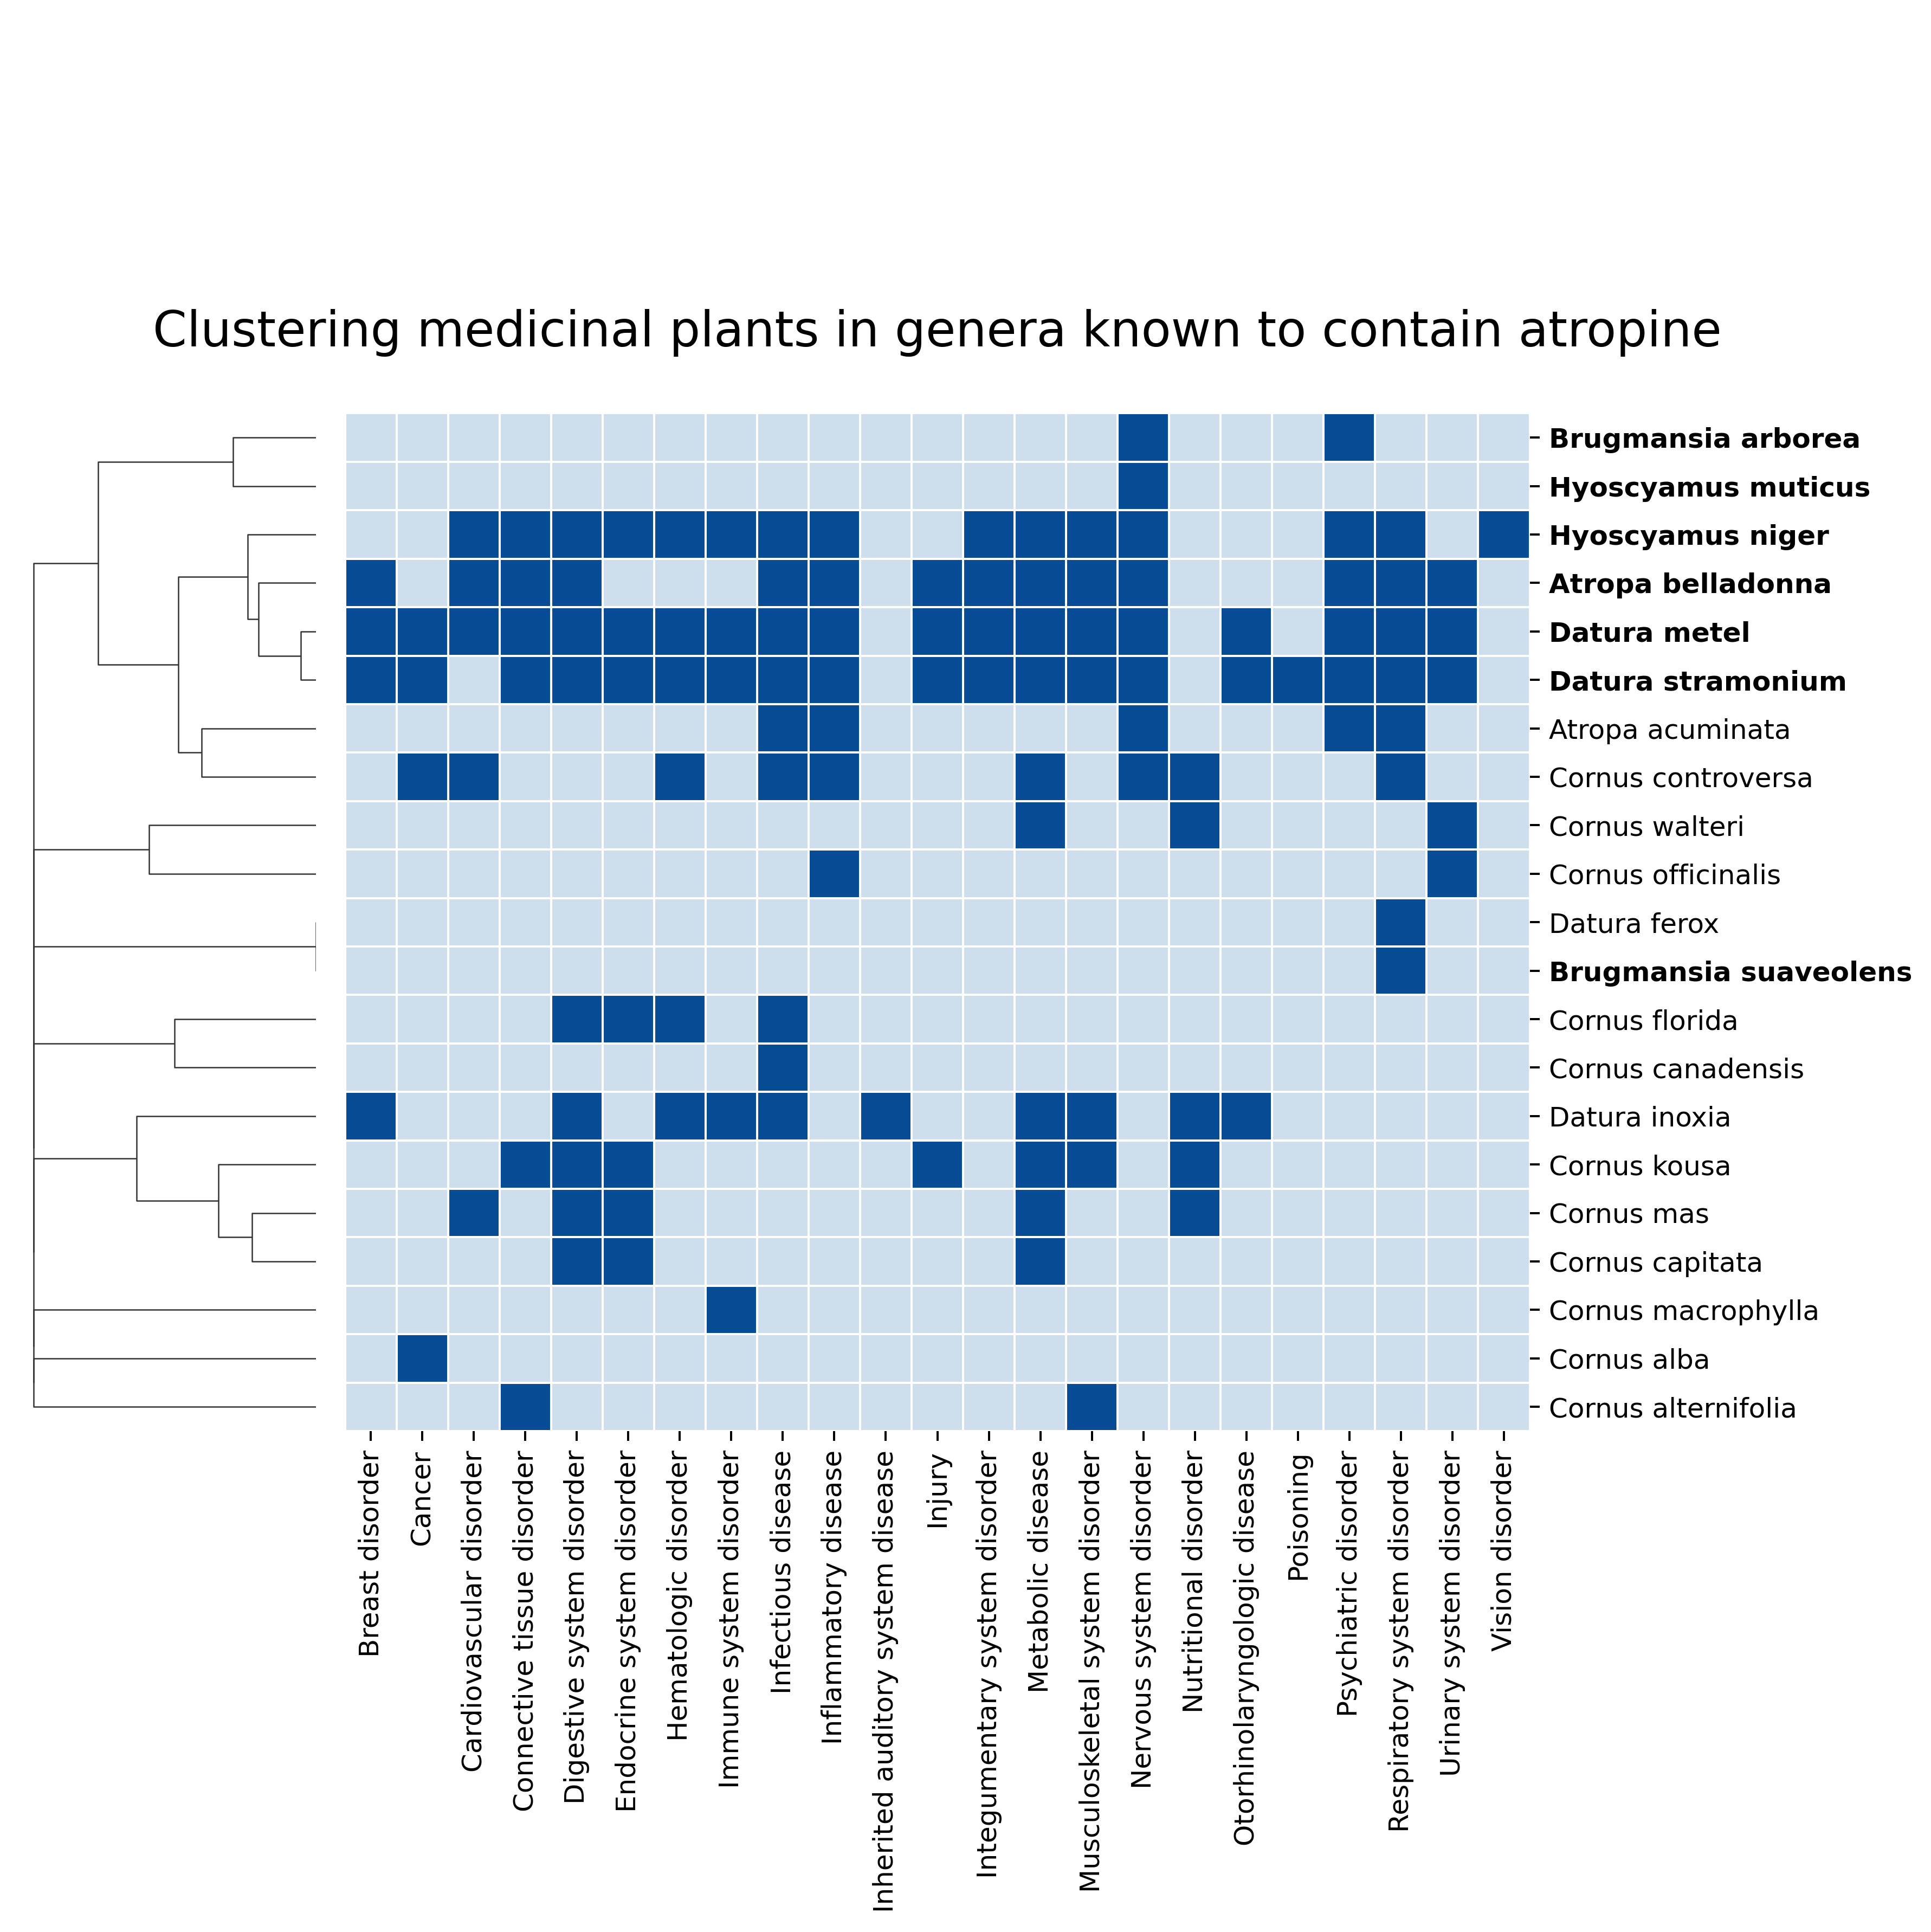

In [28]:
create_cluster(atropine_dis_distance_matrix, plants_of_interest)